# Patient Condition Classification Using Drug Reviews

## Objective  
Classify patient conditions (Depression, High Blood Pressure, Type 2 Diabetes)  
using NLP on patient drug reviews to support healthcare insights and recommendations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Replace with the full path to your file
df = pd.read_excel("drugsCom_raw.xlsx")
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [ ]:
# Dataset Overview
print(df.shape)
print("===" * 40)
print(df.info())
print("===" * 40)
print(df.describe())

(161297, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   161297 non-null  int64         
 1   drugName     161297 non-null  object        
 2   condition    160398 non-null  object        
 3   review       161297 non-null  object        
 4   rating       161297 non-null  int64         
 5   date         161297 non-null  datetime64[ns]
 6   usefulCount  161297 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 8.6+ MB
None
          Unnamed: 0         rating                           date  \
count  161297.000000  161297.000000                         161297   
mean   115923.585305       6.994377  2014-06-11 08:51:43.779983360   
min         2.000000       1.000000            2008-02-24 00:00:00   
25%     58063.000000       5.000000            2012-04-12 00:00:00   
50% 

In [ ]:
# Check for Missing Values
print(df.isnull().sum())
print("===" * 40)
print(df.duplicated().sum())

Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64
0


In [ ]:
# fix missing values
df['condition'] = df['condition'].fillna(df['condition'].mode()[0])
df.isnull().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [ ]:
# Target Condition Selection
target_conditions = [
    "Depression",
    "High Blood Pressure",
    "Diabetes, Type 2"
]

df = df[df["condition"].isin(target_conditions)]

df["condition"].value_counts()


condition
Depression             9069
Diabetes, Type 2       2554
High Blood Pressure    2321
Name: count, dtype: int64

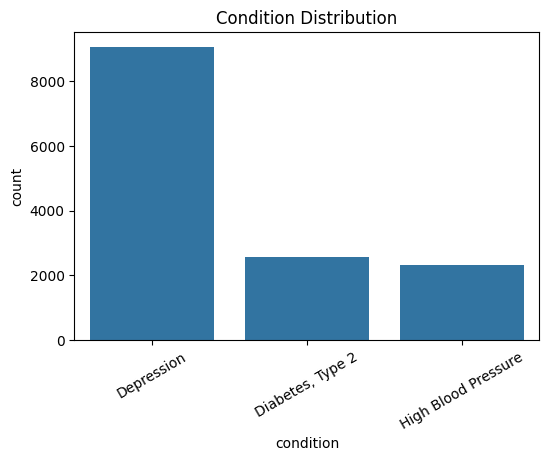

In [ ]:
# Class Distribution Visualization
plt.figure(figsize=(6,4))
sns.countplot(x="condition", data=df)
plt.title("Condition Distribution")
plt.xticks(rotation=30)
plt.show()

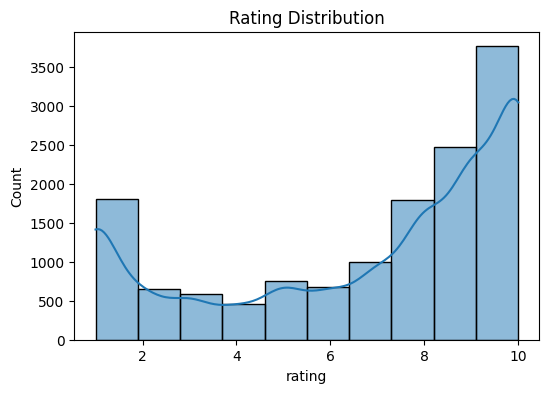

In [ ]:
# Rating Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["rating"], bins=10, kde=True)
plt.title("Rating Distribution")
plt.show()

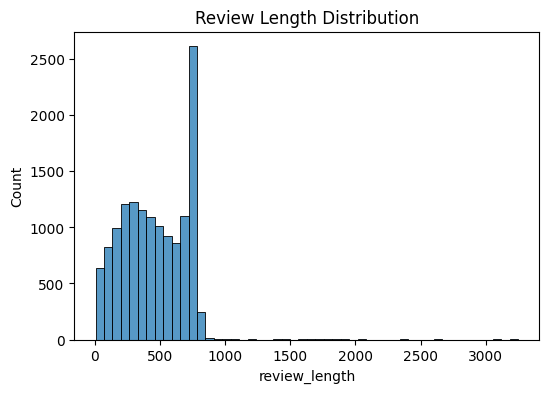

In [ ]:
# Review Length Analysis
df["review_length"] = df["review"].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df["review_length"], bins=50)
plt.title("Review Length Distribution")
plt.show()

In [ ]:
def label_sentiment(r):
    if r >= 7:
        return 'positive'
    elif r <= 4:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_sentiment)
df['sentiment'].value_counts(normalize=True) * 100

sentiment
positive    64.694492
negative    25.007172
neutral     10.298336
Name: proportion, dtype: float64

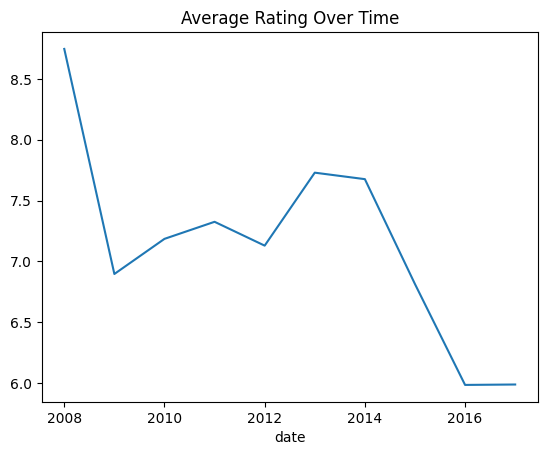

In [ ]:

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.groupby(df['date'].dt.year)['rating'].mean().plot()
plt.title('Average Rating Over Time')
plt.show()

In [ ]:
# Word Count Analysis
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

df["word_count"].describe()

count    13944.000000
mean        83.258821
std         44.834352
min          1.000000
25%         47.000000
50%         82.000000
75%        124.000000
max        601.000000
Name: word_count, dtype: float64

In [ ]:
# Sample Reviews Per Condition
for condition in target_conditions:
    print(f"\n--- {condition} ---")
    print(df[df["condition"] == condition]["review"].iloc[0][:500])


--- Depression ---
"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.

I only take Cymbalta now mostly for pain.

When I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."

--- High Blood Pressure ---
"My blood pressure has been around 160/100. Doctor prescribed Azor 40/10. Just 4 hrs later my reading showed 120/82. I was amazed. I am now on it daily. Thanks to Azor."

--- Diabetes, Type 2 ---
"Hey Guys,  It&#039;s been 4 months since my last post as I wanted to give it a few months to see how this was going to work.  So, I have been on Trulicity for six months now with Metformin.  When I hit the five month period the diarrhea, gas, sulphur belching finally subsided.  I now longer have 

### PREPROCESSING SECTION

In [ ]:
# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)        # Remove HTML
    text = re.sub(r"[^a-zA-Z\s]", "", text) # Remove special chars
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# Apply Cleaning
df["clean_review"] = df["review"].apply(clean_text)

df[["review", "clean_review"]].head()

,review,clean_review
11,"""I have taken anti-depressants for years, with...",i have taken antidepressants for years with so...
31,"""1 week on Zoloft for anxiety and mood swings....",week on zoloft for anxiety and mood swings i t...
44,"""my gp started me on Venlafaxine yesterday to ...",my gp started me on venlafaxine yesterday to h...
50,"""Hey Guys, It&#039;s been 4 months since my l...",hey guys its been months since my last post as...
67,"""This medicine saved my life. I was at my wits...",this medicine saved my life i was at my wits e...


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Apply Preprocessing
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    filtered_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]

    return " ".join(filtered_tokens)

df["processed_review"] = df["clean_review"].apply(preprocess_text)

df[["clean_review", "processed_review"]].head()

,clean_review,processed_review
11,i have taken antidepressants for years with so...,taken antidepressant year improvement mostly m...
31,week on zoloft for anxiety and mood swings i t...,week zoloft anxiety mood swing take mg morning...
44,my gp started me on venlafaxine yesterday to h...,gp started venlafaxine yesterday help depressi...
50,hey guys its been months since my last post as...,hey guy month since last post wanted give mont...
67,this medicine saved my life i was at my wits e...,medicine saved life wit end antidepressant rea...


In [ ]:
# Remove Empty Reviews
df = df[df["processed_review"].str.strip() != ""]

In [ ]:
# Final Dataset for Modeling
X = df["processed_review"]
y = df["condition"]

print(X.shape, y.shape)

(13944,) (13944,)


In [ ]:
# Word Frequency Analysis
from collections import Counter

all_words = " ".join(df["processed_review"]).split()
word_freq = Counter(all_words)

word_freq.most_common(20)

[('mg', 7963),
 ('day', 7415),
 ('effect', 6817),
 ('side', 6230),
 ('week', 6160),
 ('year', 5929),
 ('taking', 5739),
 ('depression', 5624),
 ('feel', 5424),
 ('month', 5079),
 ('started', 4311),
 ('im', 4286),
 ('time', 4042),
 ('medication', 4033),
 ('like', 3892),
 ('ive', 3721),
 ('take', 3661),
 ('first', 3595),
 ('anxiety', 3541),
 ('doctor', 3182)]

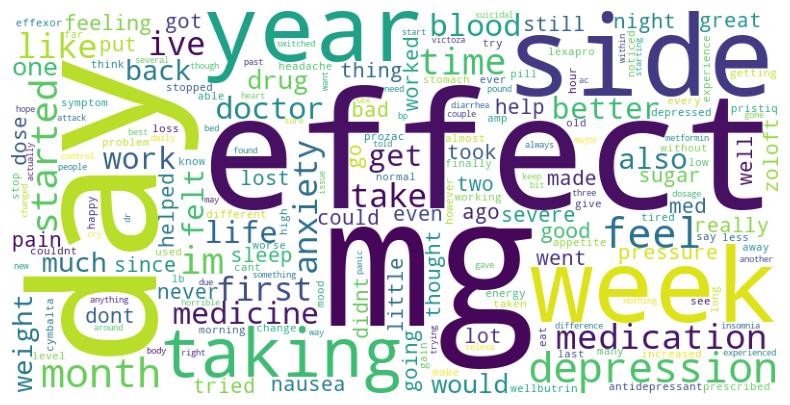

In [ ]:
# word cloud visualization
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# tokenization and stopward analysis
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def tokenize(text):
    text = str(text).lower()
    tokens = re.findall(r'[a-z]+', text)
    return [t for t in tokens if t not in ENGLISH_STOP_WORDS]

df['tokens'] = df['review'].apply(tokenize)
df['tokens'].head()

11    [taken, anti, depressants, years, improvement,...
31    [week, zoloft, anxiety, mood, swings, mg, morn...
44    [gp, started, venlafaxine, yesterday, help, de...
50    [hey, guys, s, months, post, wanted, months, g...
67    [medicine, saved, life, wits, end, anti, depre...
Name: tokens, dtype: object

In [ ]:
# top keywords per sentiment
for s in df['sentiment'].unique():
    words = [w for tokens in df[df['sentiment']==s]['tokens'] for w in tokens]
    print(s, Counter(words).most_common(15))

positive [('mg', 5525), ('t', 4774), ('depression', 4376), ('effects', 3950), ('feel', 3823), ('taking', 3543), ('years', 3379), ('day', 3000), ('m', 2965), ('started', 2775), ('ve', 2775), ('s', 2767), ('anxiety', 2764), ('life', 2649), ('like', 2595)]
negative [('t', 2050), ('mg', 1663), ('taking', 1558), ('day', 1208), ('started', 1088), ('effects', 1072), ('feel', 962), ('like', 959), ('depression', 951), ('medication', 940), ('doctor', 880), ('weeks', 875), ('m', 872), ('days', 853), ('just', 808)]
neutral [('mg', 844), ('t', 832), ('taking', 646), ('effects', 567), ('depression', 510), ('day', 508), ('m', 476), ('feel', 470), ('started', 452), ('blood', 407), ('just', 392), ('months', 386), ('ve', 386), ('like', 369), ('s', 366)]


In [ ]:
# class imbalance summary
df.groupby(['condition','sentiment']).size().unstack(fill_value=0)

sentiment,negative,neutral,positive
condition,,,
Depression,2007,854,6208
"Diabetes, Type 2",727,287,1540
High Blood Pressure,753,295,1273


### MODEL BUILDING AND EVALUATION

In [ ]:
# Import Required Libraries for Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
import time

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClass Distribution in Test Set:")
print(y_test.value_counts())

Training Set Size: 11155
Test Set Size: 2789

Class Distribution in Training Set:
condition
Depression             7255
Diabetes, Type 2       2043
High Blood Pressure    1857
Name: count, dtype: int64

Class Distribution in Test Set:
condition
Depression             1814
Diabetes, Type 2        511
High Blood Pressure     464
Name: count, dtype: int64


In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF Matrix Shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF Matrix Shape: (11155, 5000)
Number of features: 5000


In [ ]:
# Initialize Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print("Models initialized successfully!")

Models initialized successfully!


In [ ]:
# Train and Evaluate All Models
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Train
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time

    # Predict
    start_time = time.time()
    y_pred = model.predict(X_test_tfidf)
    prediction_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'prediction_time': prediction_time
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Prediction Time: {prediction_time:.4f}s")

print("\n" + "="*50)
print("All models trained successfully!")


Training Logistic Regression...
Accuracy: 0.9473
Precision: 0.9476
Recall: 0.9473
F1-Score: 0.9462
Training Time: 0.36s
Prediction Time: 0.0012s

Training Random Forest...
Accuracy: 0.9537
Precision: 0.9543
Recall: 0.9537
F1-Score: 0.9530
Training Time: 6.32s
Prediction Time: 0.0673s

Training Naive Bayes...
Accuracy: 0.9430
Precision: 0.9438
Recall: 0.9430
F1-Score: 0.9417
Training Time: 0.01s
Prediction Time: 0.0006s

Training SVM...
Accuracy: 0.9530
Precision: 0.9529
Recall: 0.9530
F1-Score: 0.9523
Training Time: 53.10s
Prediction Time: 2.1633s

Training Gradient Boosting...
Accuracy: 0.9226
Precision: 0.9264
Recall: 0.9226
F1-Score: 0.9199
Training Time: 38.37s
Prediction Time: 0.0118s

Training KNN...
Accuracy: 0.7870
Precision: 0.8427
Recall: 0.7870
F1-Score: 0.8000
Training Time: 0.01s
Prediction Time: 1.0358s

All models trained successfully!


In [ ]:
# Create Comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results],
    'Prediction Time (s)': [results[m]['prediction_time'] for m in results]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
comparison_df

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Prediction Time (s)
1,Random Forest,0.953747,0.954252,0.953747,0.952976,6.324578,0.067295
3,SVM,0.953030,0.952863,0.953030,0.952345,53.100349,2.163254
0,Logistic Regression,0.947293,0.947604,0.947293,0.946239,0.363617,0.001177
2,Naive Bayes,0.942990,0.943811,0.942990,0.941657,0.013183,0.000571
4,Gradient Boosting,0.922553,0.926391,0.922553,0.919944,38.370854,0.011755
5,KNN,0.787020,0.842673,0.787020,0.799963,0.006356,1.035828


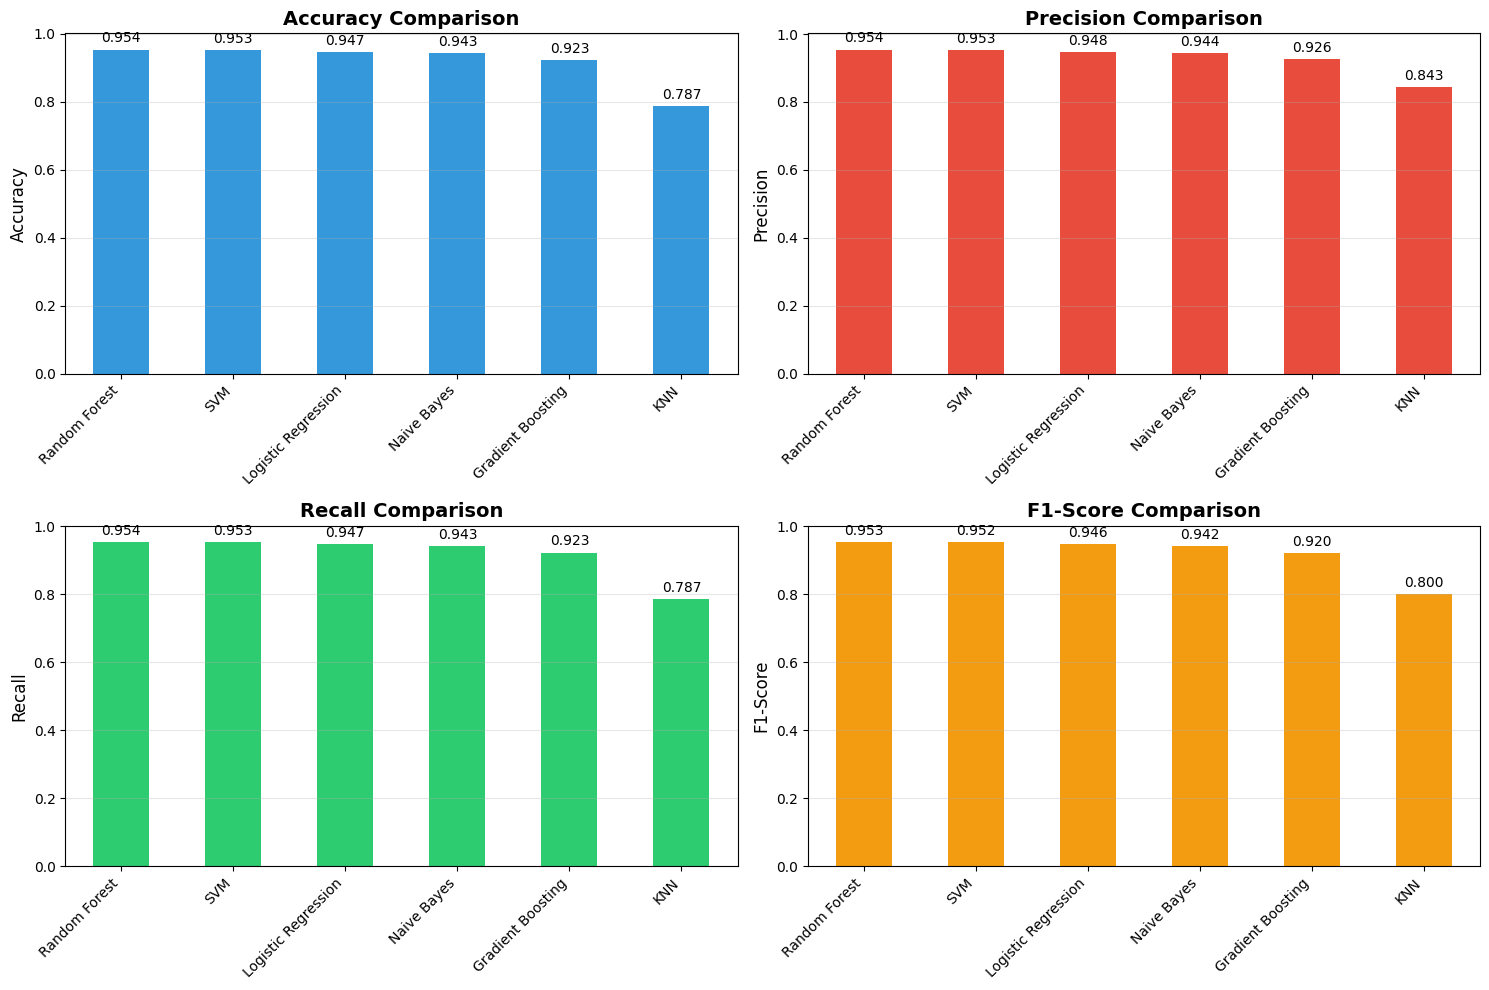

In [ ]:
# Visualize Model Comparison - Metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx//2, idx%2]
    comparison_df.plot(
        x='Model', y=metric, kind='bar',
        ax=ax, color=color, legend=False
    )
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

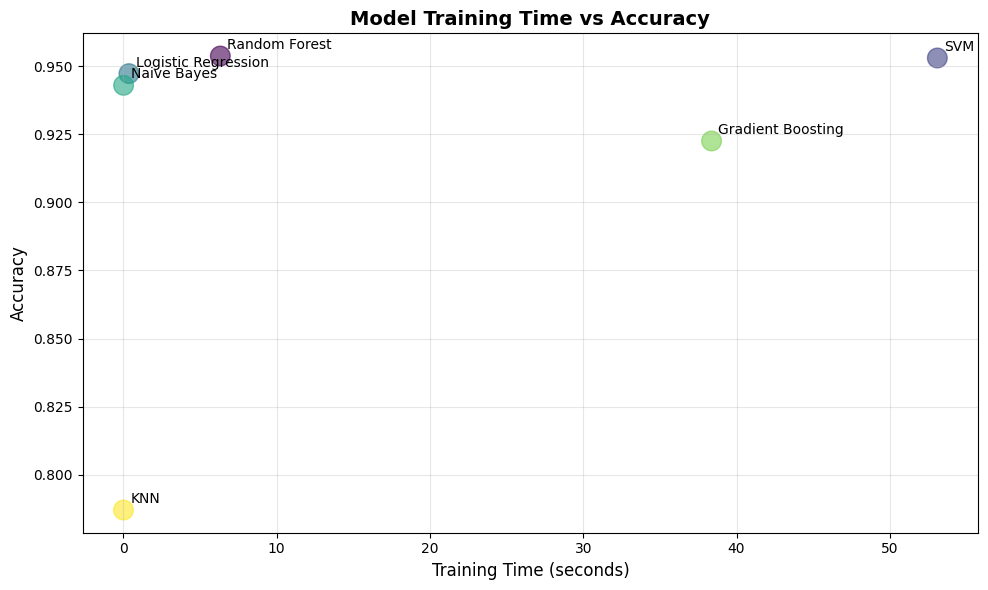

In [ ]:
# Visualize Training Time vs Accuracy
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Training Time (s)'], comparison_df['Accuracy'],
            s=200, alpha=0.6, c=range(len(comparison_df)), cmap='viridis')

for idx, row in comparison_df.iterrows():
    plt.annotate(row['Model'],
                 (row['Training Time (s)'], row['Accuracy']),
                 xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.xlabel('Training Time (seconds)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Training Time vs Accuracy', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

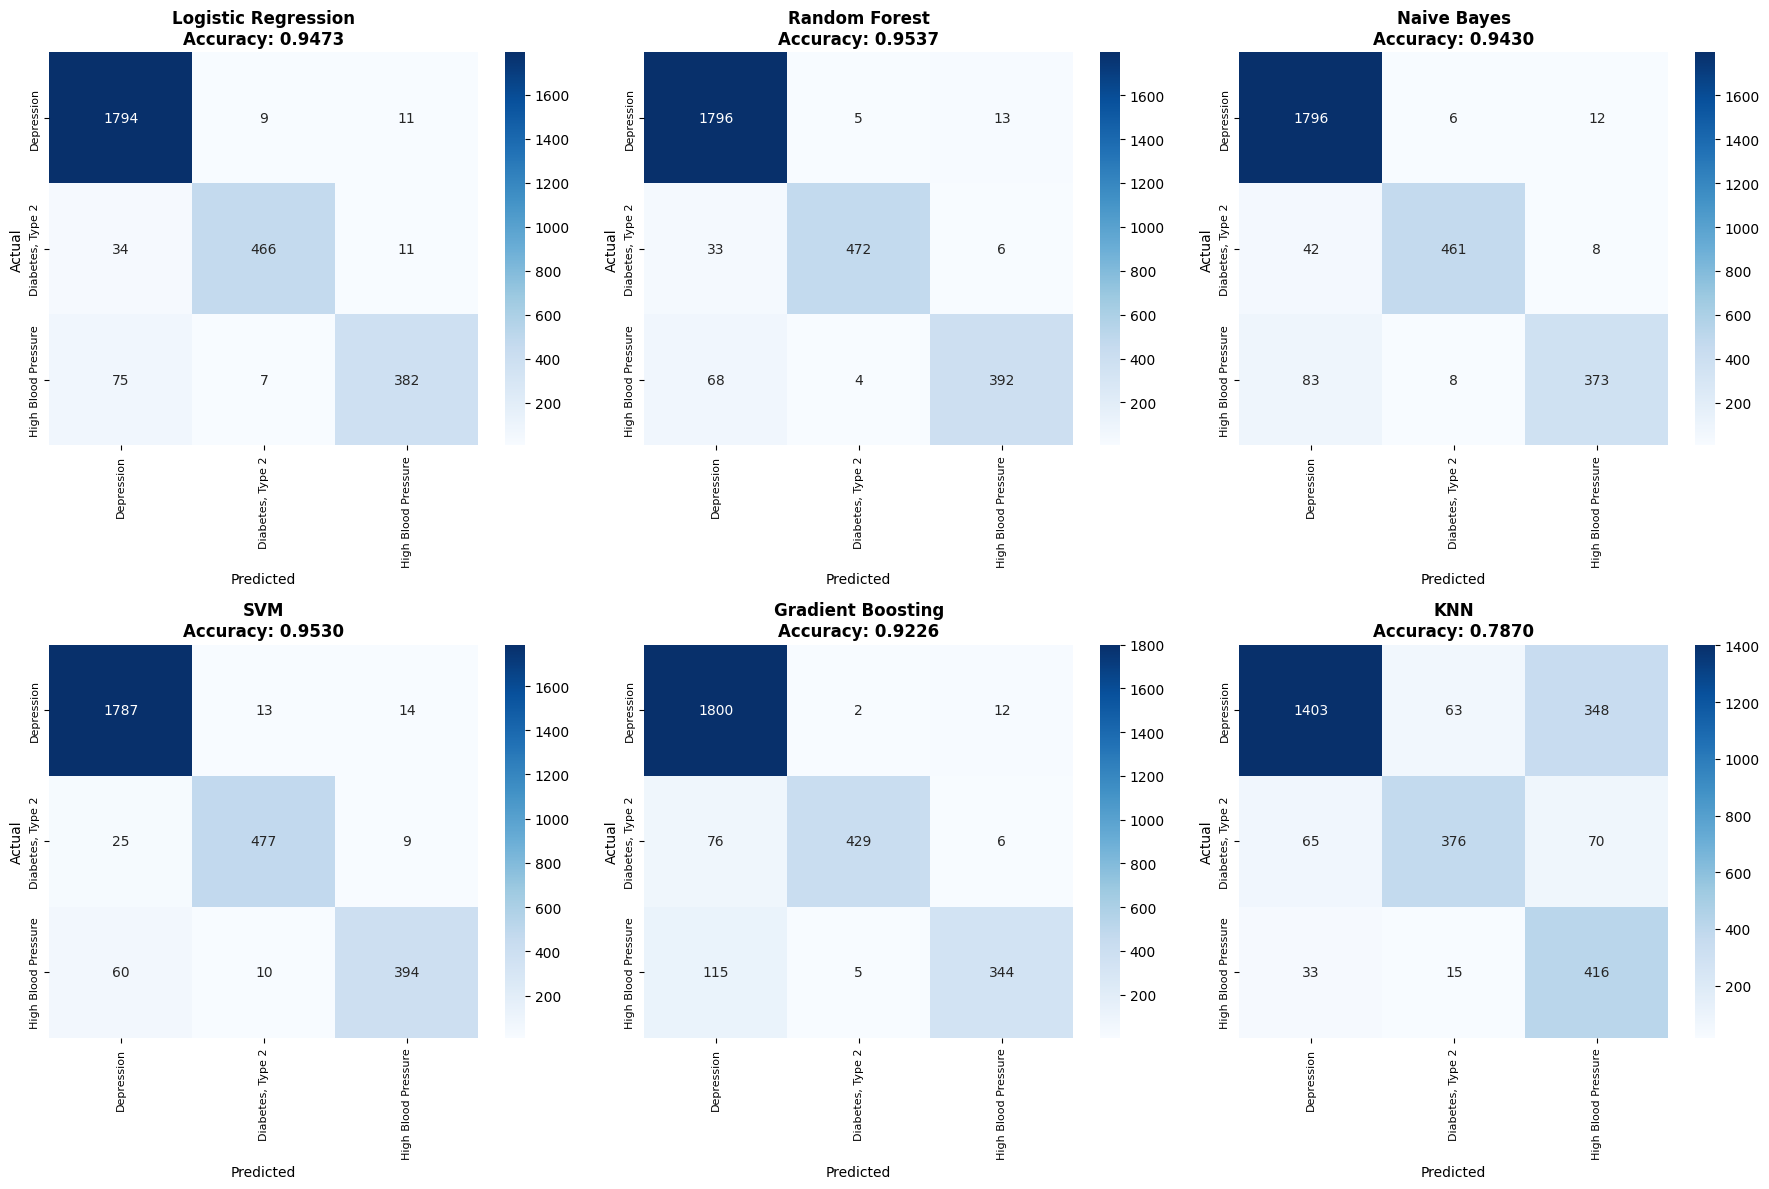

In [ ]:
# Confusion Matrices for All Models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                ax=axes[idx], cbar=True,
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))

    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Detailed Classification Reports
print("="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for name, result in results.items():
    print(f"\n{'='*80}")
    print(f"{name}")
    print("="*80)
    print(classification_report(y_test, result['y_pred'], target_names=np.unique(y_test)))
    print()

DETAILED CLASSIFICATION REPORTS

Logistic Regression
                     precision    recall  f1-score   support

         Depression       0.94      0.99      0.97      1814
   Diabetes, Type 2       0.97      0.91      0.94       511
High Blood Pressure       0.95      0.82      0.88       464

           accuracy                           0.95      2789
          macro avg       0.95      0.91      0.93      2789
       weighted avg       0.95      0.95      0.95      2789



Random Forest
                     precision    recall  f1-score   support

         Depression       0.95      0.99      0.97      1814
   Diabetes, Type 2       0.98      0.92      0.95       511
High Blood Pressure       0.95      0.84      0.90       464

           accuracy                           0.95      2789
          macro avg       0.96      0.92      0.94      2789
       weighted avg       0.95      0.95      0.95      2789



Naive Bayes
                     precision    recall  f1-score   supp

In [ ]:
# ROC-AUC Calculation for Multi-class Classification
# Binarize the labels for ROC-AUC calculation
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Calculate ROC-AUC for each model
roc_auc_scores = {}

for name, result in results.items():
    model = result['model']

    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_tfidf)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test_tfidf)
    else:
        continue

    # Calculate ROC-AUC for each class and average
    try:
        roc_auc = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')
        roc_auc_scores[name] = roc_auc
        results[name]['roc_auc'] = roc_auc
    except:
        roc_auc_scores[name] = None

print("ROC-AUC Scores (Weighted Average):")
print("="*50)
for name, score in roc_auc_scores.items():
    if score is not None:
        print(f"{name:25s}: {score:.4f}")
    else:
        print(f"{name:25s}: N/A")

ROC-AUC Scores (Weighted Average):
Logistic Regression      : 0.9947
Random Forest            : 0.9941
Naive Bayes              : 0.9931
SVM                      : 0.9949
Gradient Boosting        : 0.9884
KNN                      : 0.9362


Plotting ROC Curves for: SVM


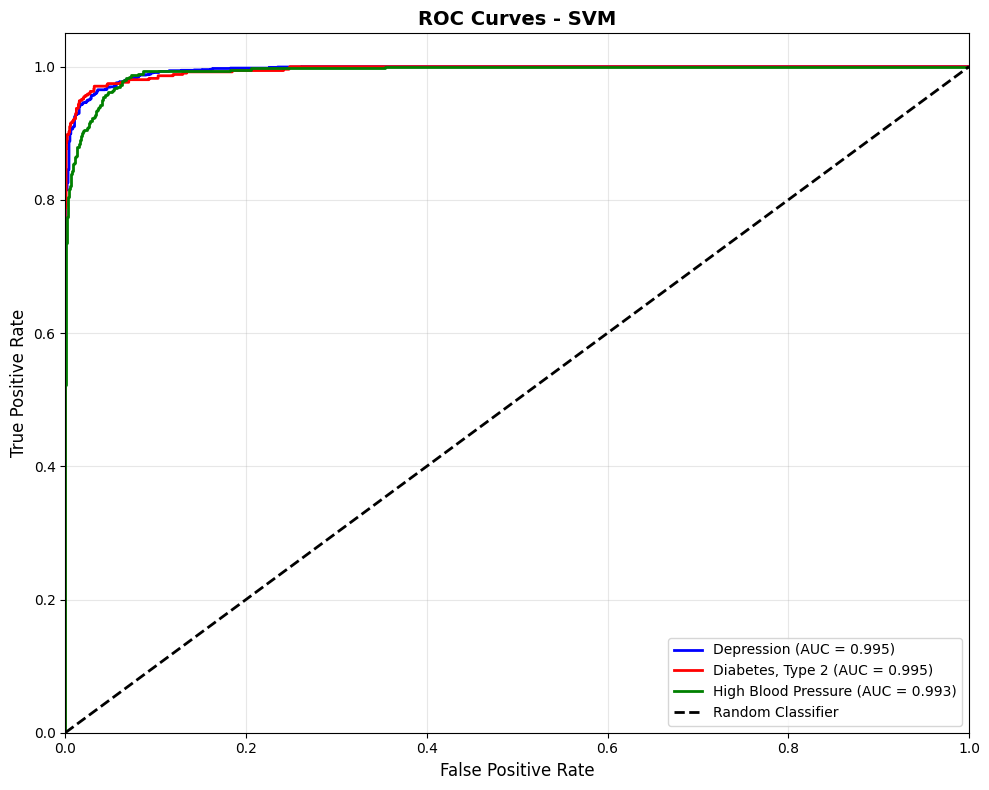

In [ ]:
# ROC Curves for Best Model (Logistic Regression or best performer)
best_model_name = max(roc_auc_scores, key=lambda k: roc_auc_scores[k] if roc_auc_scores[k] else 0)
best_model = results[best_model_name]['model']

print(f"Plotting ROC Curves for: {best_model_name}")

# Get prediction probabilities
y_score = best_model.predict_proba(X_test_tfidf)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green']
for i, (color, class_name) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Final Summary Table with ROC-AUC
final_comparison = comparison_df.copy()
final_comparison['ROC-AUC'] = final_comparison['Model'].map(lambda x: roc_auc_scores.get(x, None))

print("\n" + "="*100)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*100)
print(final_comparison.to_string(index=False))
print("="*100)

# Identify best model
best_overall = final_comparison.loc[final_comparison['Accuracy'].idxmax()]
print(f"\n🏆 BEST MODEL: {best_overall['Model']}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
if best_overall['ROC-AUC'] is not None:
    print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")


FINAL MODEL COMPARISON SUMMARY
              Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)  Prediction Time (s)  ROC-AUC
      Random Forest  0.953747   0.954252 0.953747  0.952976           6.324578             0.067295 0.994055
                SVM  0.953030   0.952863 0.953030  0.952345          53.100349             2.163254 0.994924
Logistic Regression  0.947293   0.947604 0.947293  0.946239           0.363617             0.001177 0.994658
        Naive Bayes  0.942990   0.943811 0.942990  0.941657           0.013183             0.000571 0.993069
  Gradient Boosting  0.922553   0.926391 0.922553  0.919944          38.370854             0.011755 0.988414
                KNN  0.787020   0.842673 0.787020  0.799963           0.006356             1.035828 0.936192

🏆 BEST MODEL: Random Forest
   Accuracy: 0.9537
   F1-Score: 0.9530
   ROC-AUC: 0.9941


In [ ]:
import pickle
import os

# Create directory
os.makedirs('models', exist_ok=True)

# The 'best_model' variable should exist from your training code
# The 'tfidf' variable should exist from your vectorization step

# Save model
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("✓ Model files exported!")
print("Location: models/best_model.pkl, models/tfidf_vectorizer.pkl")

✓ Model files exported!
Location: models/best_model.pkl, models/tfidf_vectorizer.pkl
